/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 39s 253ms/step - loss: 0.0197 - val_loss: 1.1615e-05
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 42s 260ms/step - loss: 0.0011 - val_loss: 1.3789e-05
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - loss: 0.0012 - val_loss: 7.5476e-06
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 33s 251ms/step - loss: 0.0011 - val_loss: 1.8418e-04
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 42s 262ms/step - loss: 0.0011 - val_loss: 5.7132e-06
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - loss: 9.6420e-04 - val_loss: 3.2903e-05
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - loss: 9.2473e-04 - val_loss: 5.6874e-06
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 42s 260ms/step - loss: 9.5532e-04 - val_loss: 1.3216e-05
Epoch 9/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - loss: 6.8890e-04 - val_loss: 2.2637e-05
Epoch 10/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 39s 244ms/step - loss: 8.8700e-04 - val_loss: 1.0295e-05
Epoch 11/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 254m

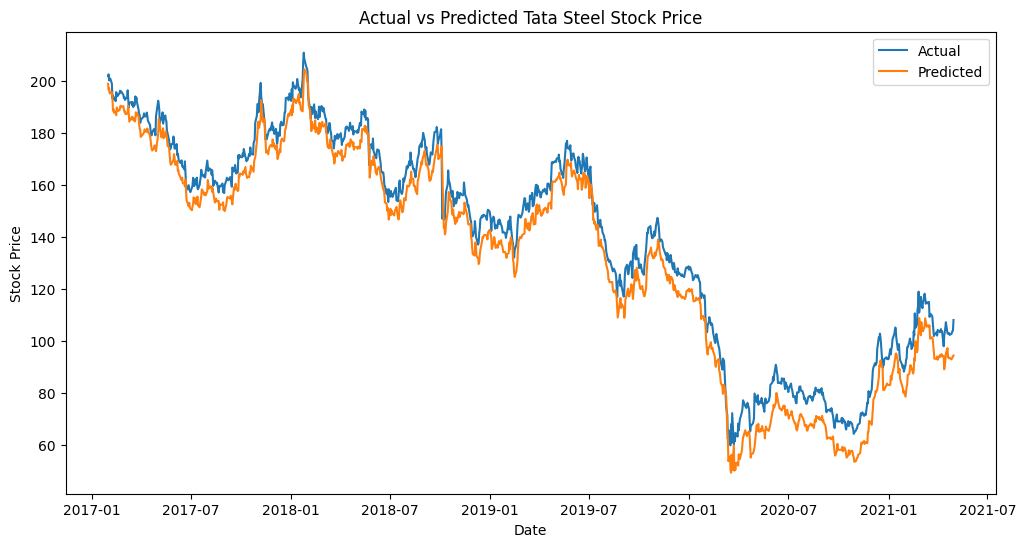

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load dataset (Ensure dataset is loaded correctly with proper datetime parsing)
df = pd.read_csv('ONGC.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]  # Use closing price for prediction

# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

# Create sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Choose sequence length
X, y = create_sequences(df_scaled, seq_length)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input to match GRU expected shape (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build GRU Model
model = Sequential([
    GRU(units=256, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    GRU(units=128, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make Predictions
y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))  # Convert back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

test_dates = df.index[-len(y_test):]  # Get corresponding dates

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual')
plt.plot(test_dates, y_test_pred, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Tata Steel Stock Price')
plt.show()
